In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import shutil
import kagglehub
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from Class_implementations import Graphics, DataProcessor, KNN


c:\Users\duope\Documentos\MegaSync\UAQ\9_Semestre\Ap_Algoritmos_IA\E2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
################################ Data Loading ################################
csv_name = "diabetes_dataset.csv"

# Download dataset if it doesn't exist
if (not os.path.exists(csv_name)):
    path = kagglehub.dataset_download("mohankrishnathalla/diabetes-health-indicators-dataset")
    print("Path to dataset files:", path)

    # move dataset to local directory
    try:
        path = shutil.move(os.path.join(path, csv_name), ".")
        print("New path to dataset files:", path)
    except:
        print("Error moving dataset files")
else:
    print("Dataset already exists in current directory")

# Read the data
df = pd.read_csv(csv_name)


Dataset already exists in current directory


In [3]:
################################ Initial Data Cleaning ################################

# Print the first 5 rows of the DataFrame
print(df.head())

# Calculate the number of missing values in each column
missing_values = df.isnull().sum().sum()
if missing_values > 0:
    print(f"{missing_values} missing values in the dataset")
    # Drop rows with missing values if necessary
    df_dropped = df.dropna()
else:
    print("No missing values in the dataset")
    df_dropped = df.copy()

# Remove diabetes risk column as it may be a target variable
df_dropped = df_dropped.drop("diabetes_risk_score", axis=1)
print("Cleaned dataframe:", df_dropped.head())

# Count the number of rows and columns
print("Dataframe shape:", df_dropped.shape)

# Get numerical columns
num_columns = df_dropped.select_dtypes(include=[np.number]).columns
print("Numerical columns:", num_columns)

# Get categorical columns
cat_columns = df_dropped.select_dtypes(include= 'object').columns
print("Categorical columns:", cat_columns)

# Print unique values for non numerical columns
for col in df_dropped.columns:
    if df_dropped[col].dtype == 'object': # Categorical columns
        print(f"Unique values for {col}: {df_dropped[col].unique()}")


   age  gender ethnicity education_level  income_level employment_status  \
0   58    Male     Asian      Highschool  Lower-Middle          Employed   
1   48  Female     White      Highschool        Middle          Employed   
2   60    Male  Hispanic      Highschool        Middle        Unemployed   
3   74  Female     Black      Highschool           Low           Retired   
4   46    Male     White        Graduate        Middle           Retired   

  smoking_status  alcohol_consumption_per_week  \
0          Never                             0   
1         Former                             1   
2          Never                             1   
3          Never                             0   
4          Never                             1   

   physical_activity_minutes_per_week  diet_score  ...  hdl_cholesterol  \
0                                 215         5.7  ...               41   
1                                 143         6.7  ...               55   
2                

Outliers removed: 9855 rows.
Dataframe shape after removing outliers: (90145, 30)
Subsampled down to 9014 rows from 90145 rows


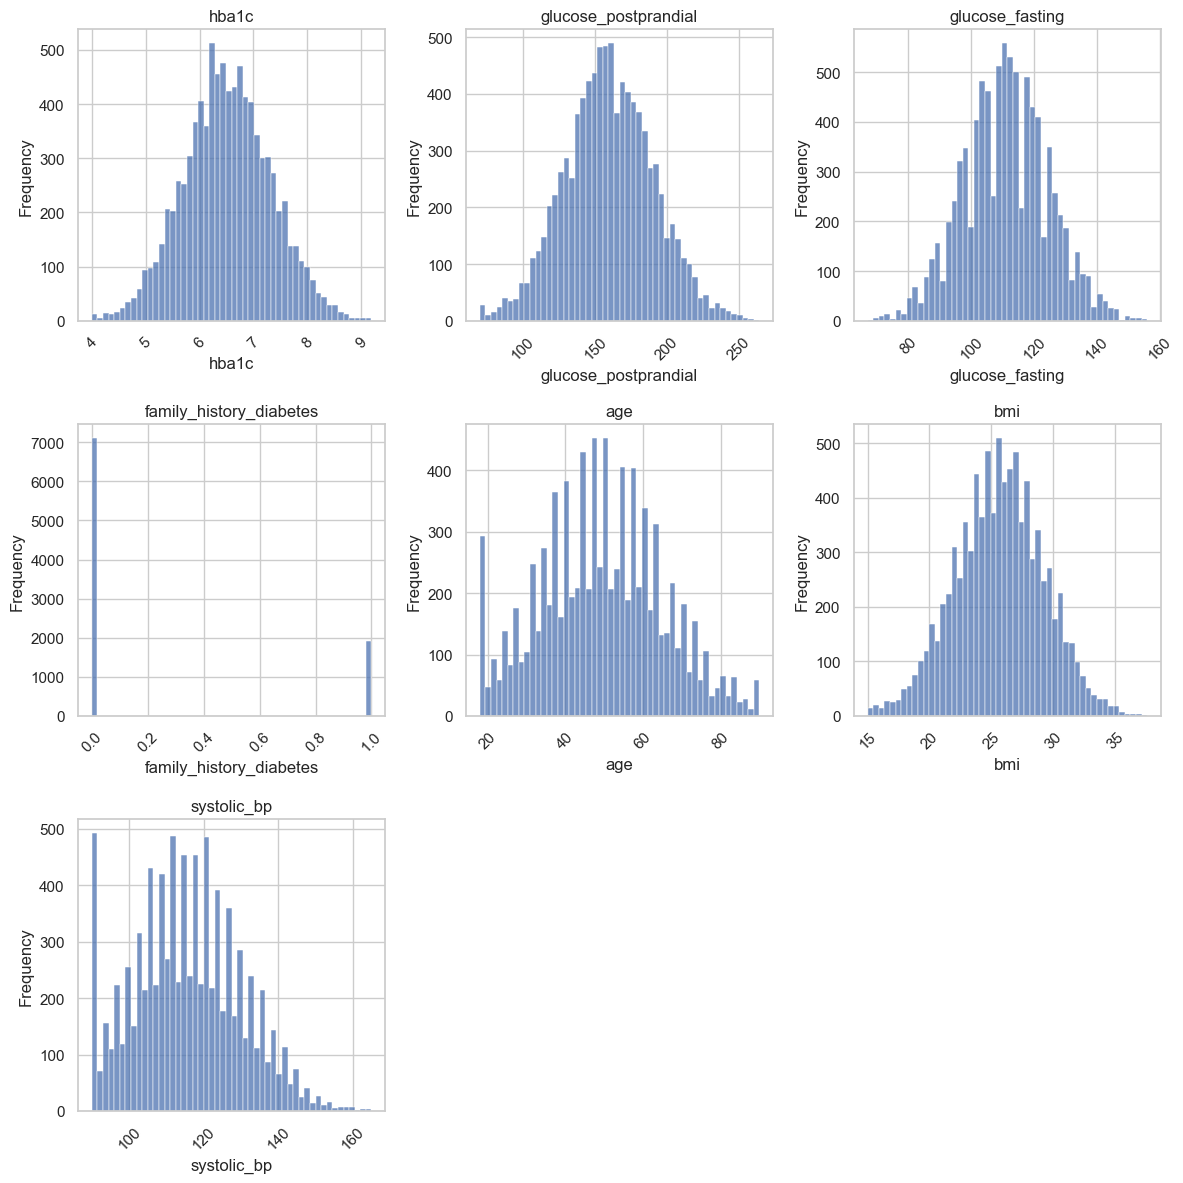

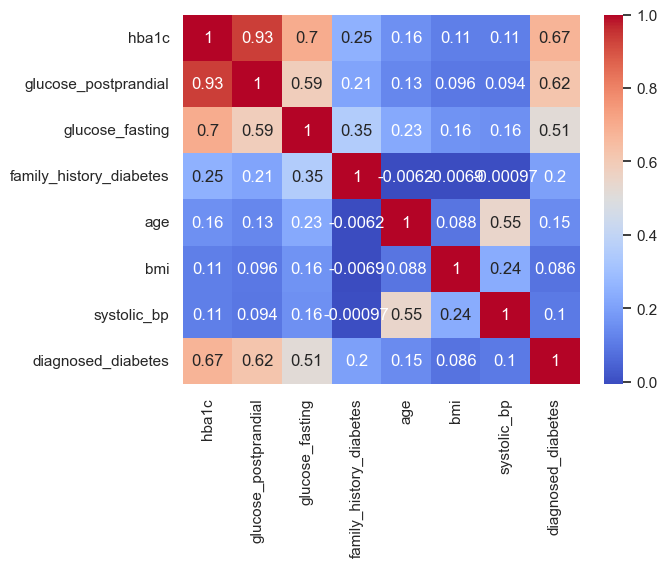

Too many columns to show scatter matrix


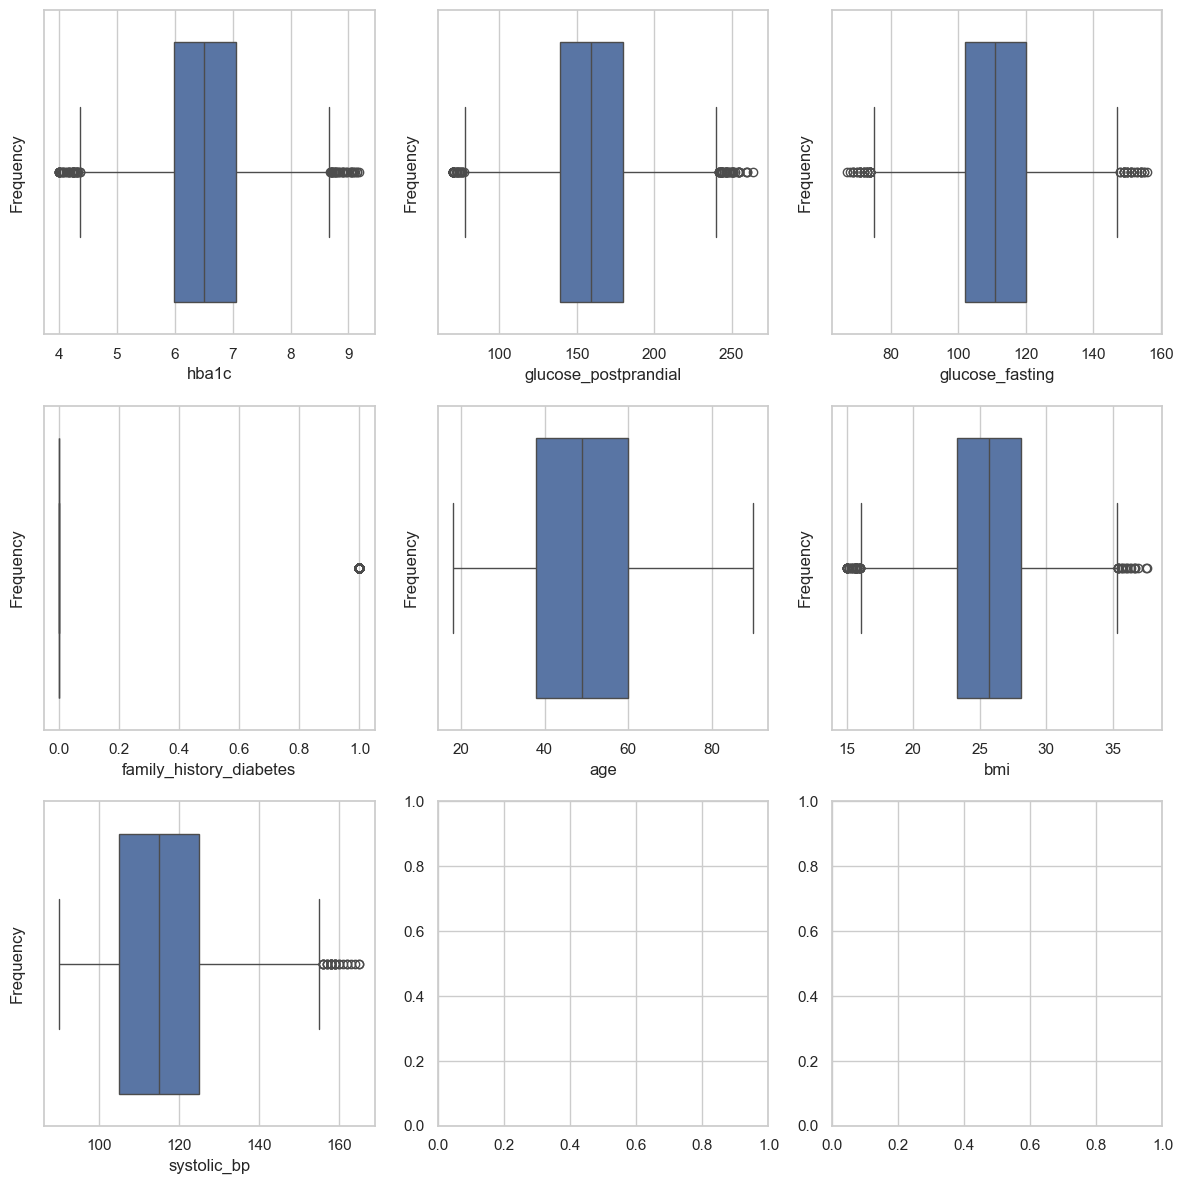

In [4]:
################################ EDA Visualization #################################

# Create DataProcessor object from cleaned columns
processor = DataProcessor(df_dropped)

# Remove outliers from numerical columns which are not binary
cols_outlier_check = ["age", "alcohol_consumption_per_week", "physical_activity_minutes_per_week", "diet_score", "sleep_hours_per_day", "screen_time_hours_per_day", "hypertension_history", "cardiovascular_history", "bmi", "waist_to_hip_ratio", "systolic_bp", "diastolic_bp", "heart_rate", "cholesterol_total", "hdl_cholesterol", "ldl_cholesterol", "triglycerides", "glucose_fasting", "glucose_postprandial", "insulin_level", "hba1c"]
processor.remove_outliers(cols_outlier_check, threshold=2.0)
df_dropped = processor.get_data() # Update dataframe using a copy
print("Dataframe shape after removing outliers:", df_dropped.shape)

# Subsample data
df_subsampled = processor.subsample_data(fraction=0.1)
graphics = Graphics(df_subsampled)

# Show correlation matrix
if False:
    graphics_total = Graphics(df_dropped) # Important to use the total dataset to show correlation matrix
    graphics_total.show_correlation_matrix(num_columns)

# Based on correlation matrix above, select important numerical attributes with correlation > 0.1, ordered by correlation
important_attributes = ["hba1c", "glucose_postprandial", "glucose_fasting", "family_history_diabetes", "age", "bmi", "systolic_bp"]
important_attributes_w_target = important_attributes + ["diagnosed_diabetes"]

important_columns = df_subsampled[important_attributes].columns
important_columns_w_target = df_subsampled[important_attributes_w_target].columns

# See distribution of important attributes
graphics.show_histograms(important_columns)
# Confirm correlation matrix values
graphics.show_correlation_matrix(important_columns_w_target)

# Show scatter matrix
if True:
    graphics.show_scatter_matrix(important_columns_w_target)

# Show boxplots to check for outliers
if True:
    graphics.show_boxplots(important_columns)


In [5]:
################################ Normalization ################################

# Normalize numerical data
processor = DataProcessor(df_dropped)
cols_to_norm = df_dropped.select_dtypes(include=[np.number]).columns.tolist()
if "diagnosed_diabetes" in cols_to_norm:
    cols_to_norm.remove("diagnosed_diabetes")
norm_df = processor.normalize_data(cols_to_norm)

# Check if done successfully
print(norm_df['age'].head())


0    0.555556
1    0.416667
2    0.583333
3    0.777778
4    0.388889
Name: age, dtype: float64


In [6]:
################################ Encoding #####################################

# Drop rows with gender = Other as it not an useful feature
norm_df = norm_df[norm_df['gender'] != 'Other']

# Convert object columns to numeric codes
# Encoding guide:
# Gender: Male = 0, Female = 1
# Ethnicity: Asian = 0, White = 1, Hispanic = 2, Black = 3, Other = 4
# Education level: Highschool = 0, Graduate = 1, Postgraduate = 2, No formal = 3
# Income level: Lower-Middle = 0, Middle = 1, Low = 2, Upper-Middle = 3, High = 4
# Employment status: Employed = 0, Unemployed = 1, Retired = 2, Student = 3
# Smoking status: Never = 0, Former = 1, Current = 2
# Diabetes stage: Type 2 = 0, No Diabetes = 1, Pre-Diabetes = 2, Gestational = 3, Type 1 = 4
encoded_df = norm_df.copy()
for col in norm_df.columns:
    if norm_df[col].dtype == 'object':
        encoded_df[col] = norm_df[col].astype('category').cat.codes

# Print dtypes to check if encoding was successful
print(encoded_df.dtypes)


age                                   float64
gender                                   int8
ethnicity                                int8
education_level                          int8
income_level                             int8
employment_status                        int8
smoking_status                           int8
alcohol_consumption_per_week          float64
physical_activity_minutes_per_week    float64
diet_score                            float64
sleep_hours_per_day                   float64
screen_time_hours_per_day             float64
family_history_diabetes               float64
hypertension_history                  float64
cardiovascular_history                float64
bmi                                   float64
waist_to_hip_ratio                    float64
systolic_bp                           float64
diastolic_bp                          float64
heart_rate                            float64
cholesterol_total                     float64
hdl_cholesterol                   

cols_to_check: ['gender', 'ethnicity', 'education_level', 'income_level', 'employment_status', 'smoking_status', 'diabetes_stage', 'diagnosed_diabetes']


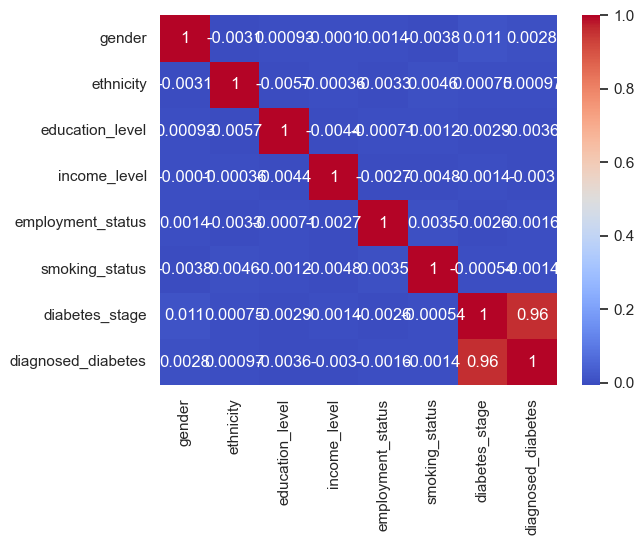

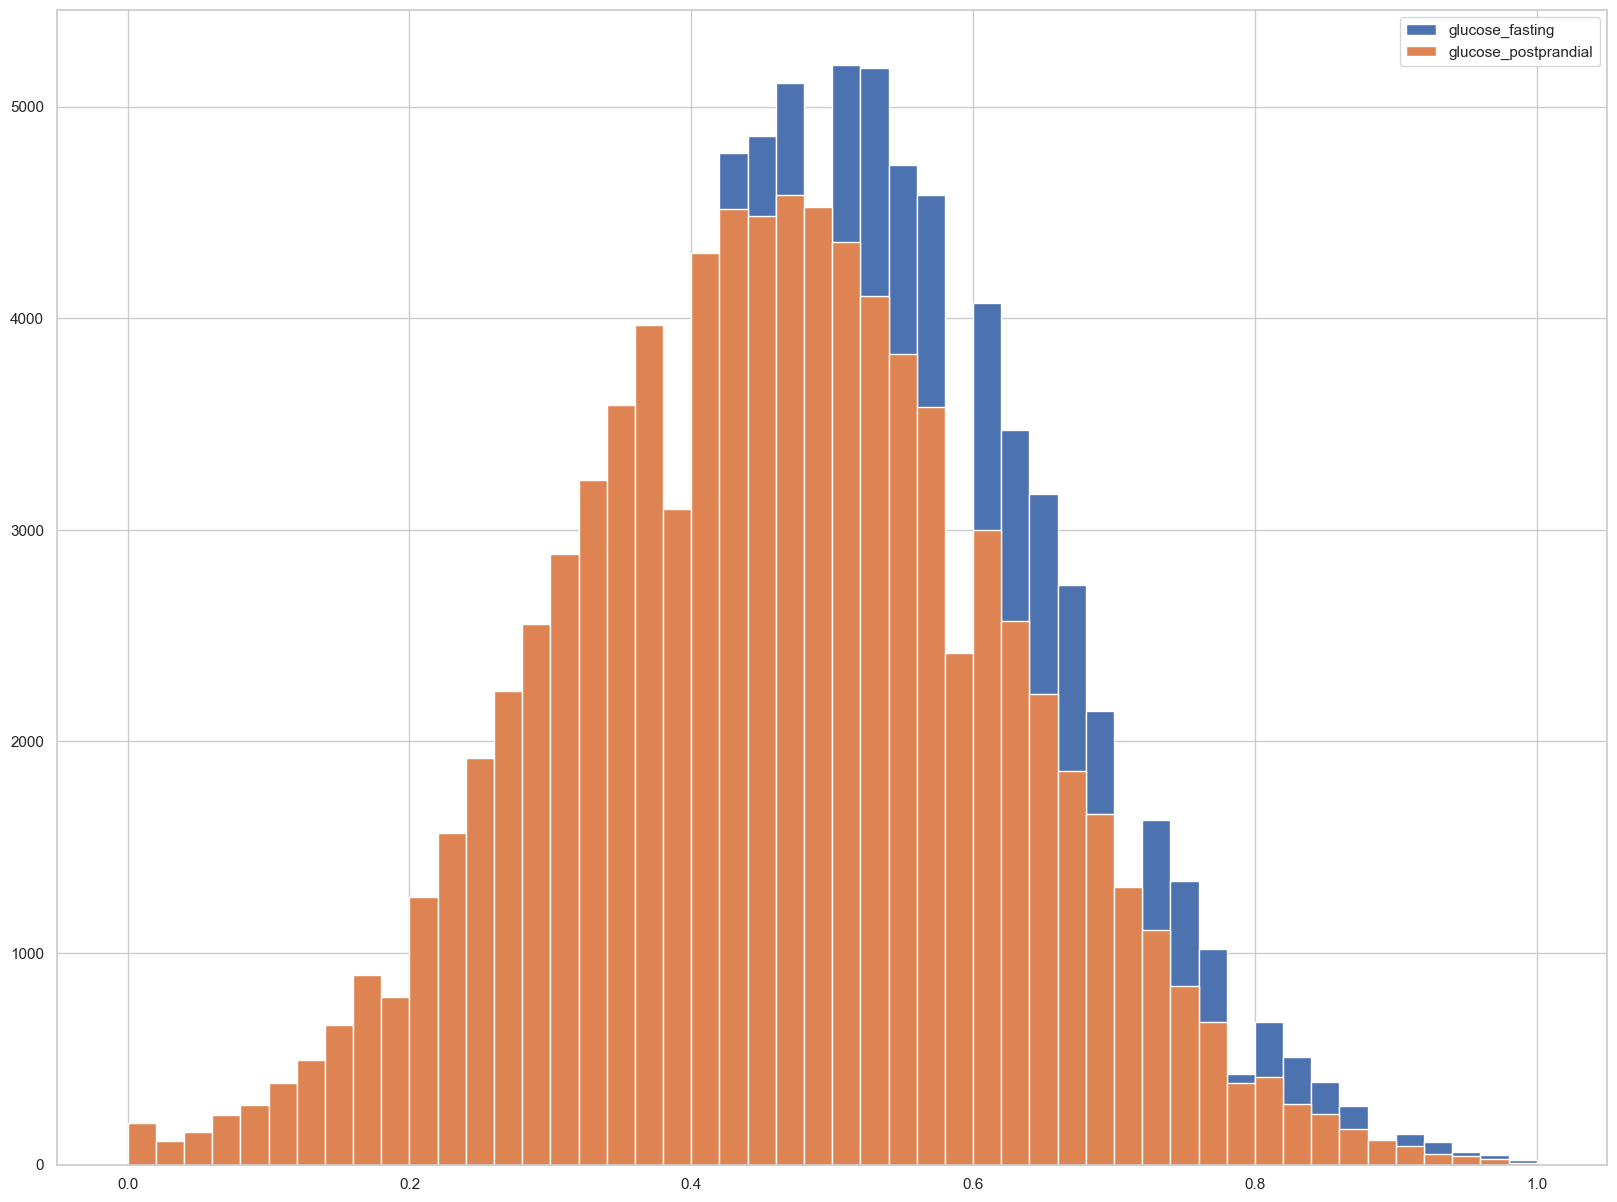

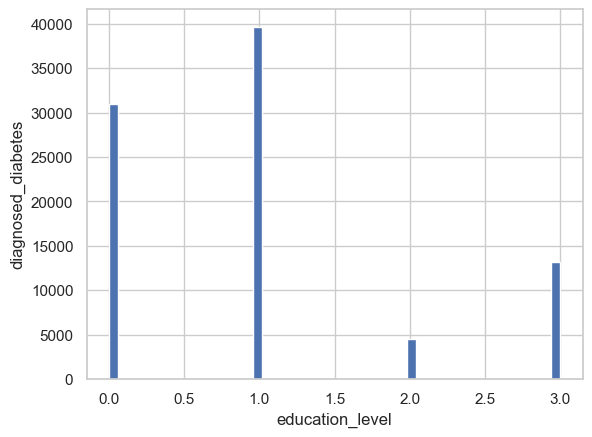

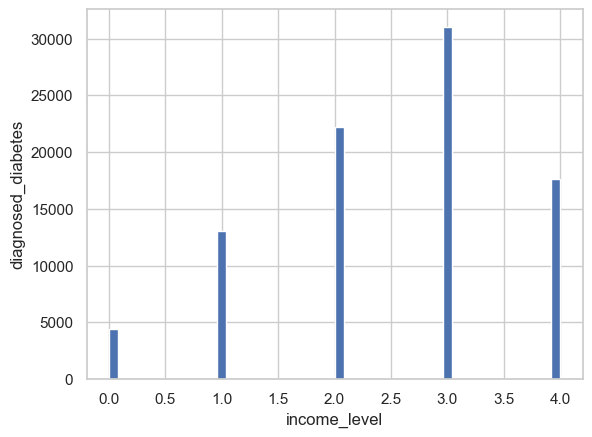

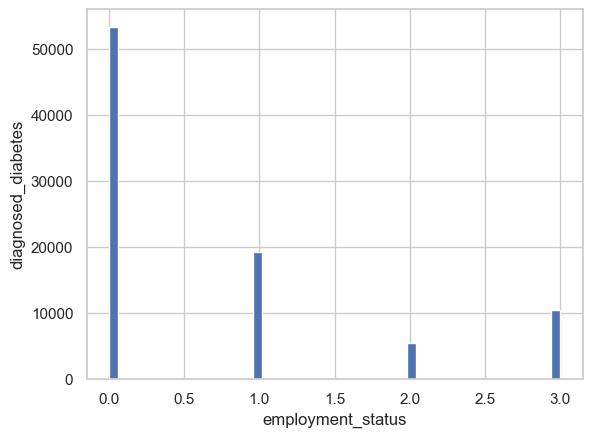

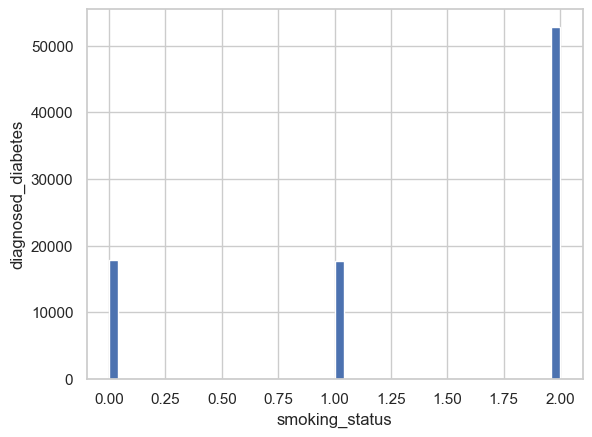

In [7]:
################################ EDA Visualization Part 2 ################################

# Update classes
processor = DataProcessor(encoded_df)
graphics = Graphics(encoded_df) # Update Graphics object with encoded data

# check for correlation matrix values now for categorical data
cols_to_check = cat_columns.tolist() + ['diagnosed_diabetes']
print("cols_to_check:", cols_to_check)
graphics.show_correlation_matrix(cols_to_check)
# After encoding, correlation matrix values show little correlation with target variable

graphics.compare_hist("glucose_fasting", "glucose_postprandial")
################# Histograms #################
# Histogram of education level vs diagnosed_diabetes
graphics.show_hist_axis("education_level", "diagnosed_diabetes")
# It shows that lower education level has higher count of diagnosed diabetes

# Histogram of income level vs diagnosed_diabetes
graphics.show_hist_axis("income_level", "diagnosed_diabetes")
# Shows that higher income level has higher count of diagnosed diabetes, but may be due to having the chance to be diagnosed

# Histogram of employment status vs diagnosed_diabetes
graphics.show_hist_axis("employment_status", "diagnosed_diabetes")
# Shows that employed has higher count of diagnosed diabetes

# Histogram of smoking status vs diagnosed_diabetes
graphics.show_hist_axis("smoking_status", "diagnosed_diabetes")
# Shows that current smoking has higher count of diagnosed diabetes

important_attributes = ["hba1c", "glucose_postprandial", "glucose_fasting", "family_history_diabetes", "age", "bmi", "systolic_bp", "smoking_status", "employment_status", "education_level", "income_level"]
important_attributes_w_target = important_attributes + ["diagnosed_diabetes"]


Subsampled down to 8833 rows from 88335 rows


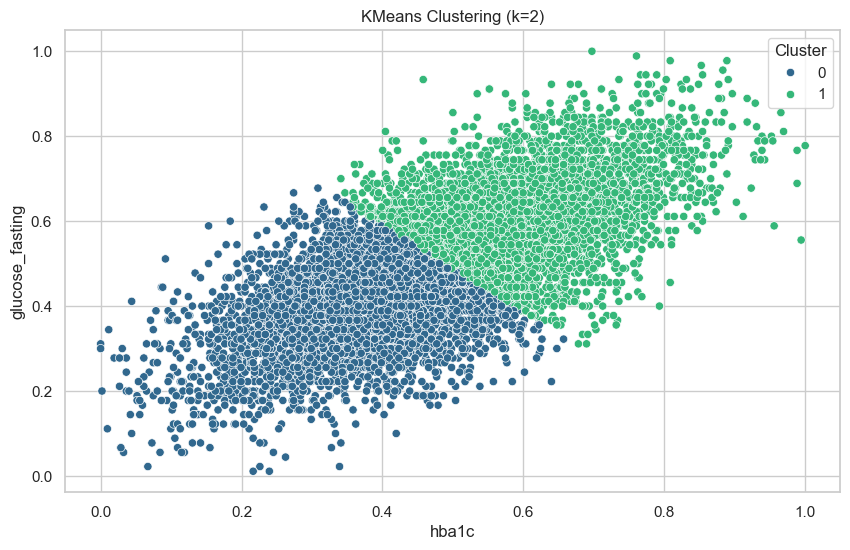

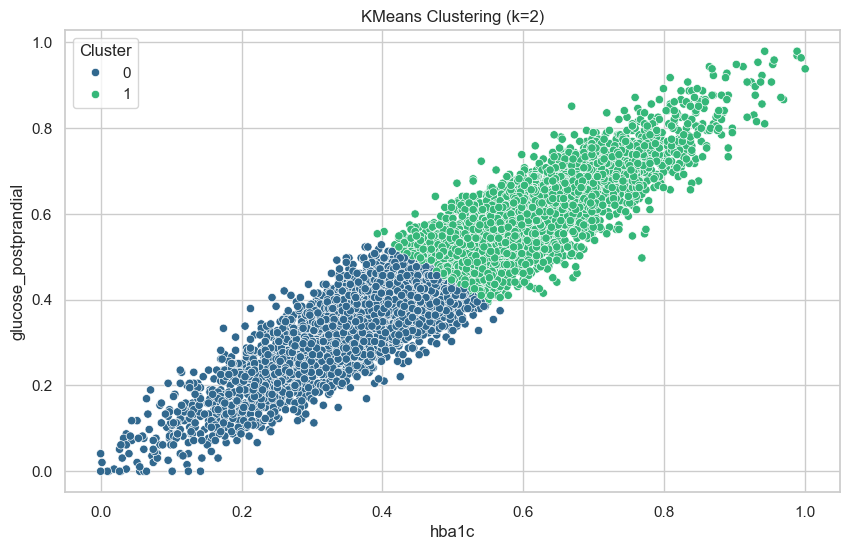

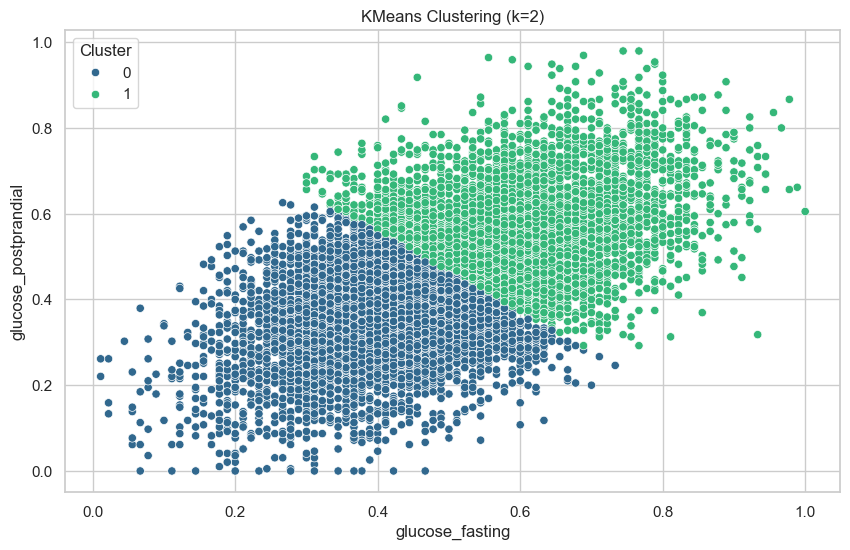

In [8]:
################# KMeans Clustering #################
# Update objects from class with cleaned columns
df_subsampled_num_encoded = processor.subsample_data(fraction=0.1)
data_processor = DataProcessor(df_subsampled_num_encoded)

# Show kmeans clustering
# Using hba1c and glucose fasting as they have the highest correlation with target variable
data_processor.plot_kmeans_clustering(["hba1c","glucose_fasting"], n_clusters=2)
# Now test for hba1c and glucose_postprandial
data_processor.plot_kmeans_clustering(["hba1c","glucose_postprandial"], n_clusters=2)
# Now test for glucose fasting and glucose_postprandial
data_processor.plot_kmeans_clustering(["glucose_fasting","glucose_postprandial"], n_clusters=2)


In [9]:
####################################### Modeling #########################################

# IMPORTANT: Use 5% to 10% of the dataset for training and testing, knn is heavy and takes a lot of time to run
subsampled_df = processor.subsample_data(fraction=0.05)
subsampled_processor = DataProcessor(subsampled_df)
train_df, test_df = subsampled_processor.train_test_split(test_size=0.2)
print(train_df.shape)
print(test_df.shape)


Subsampled down to 4416 rows from 88335 rows
(3532, 30)
(884, 30)


Accuracy for Decision Tree: 0.8631221719457014


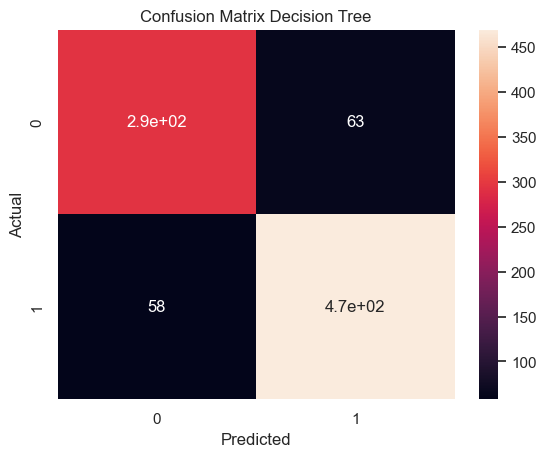

In [10]:
################# Decision Tree Library #################

if True:
    # Create Decision Tree object
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(train_df[important_attributes], train_df['diagnosed_diabetes'])

    # Make predictions
    predictions = decision_tree.predict(test_df[important_attributes])
    # Calculate accuracy
    correct = sum(predictions == test_df['diagnosed_diabetes'])
    print(f"Accuracy for Decision Tree: {correct/len(test_df)}")
    decision_tree_accuracy = correct/len(test_df)
    # Plot confusion matrix
    cm = confusion_matrix(test_df['diagnosed_diabetes'], predictions)
    sns.heatmap(cm, annot=True)
    plt.title("Confusion Matrix Decision Tree")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Accuracy for KNN: 0.7432126696832579


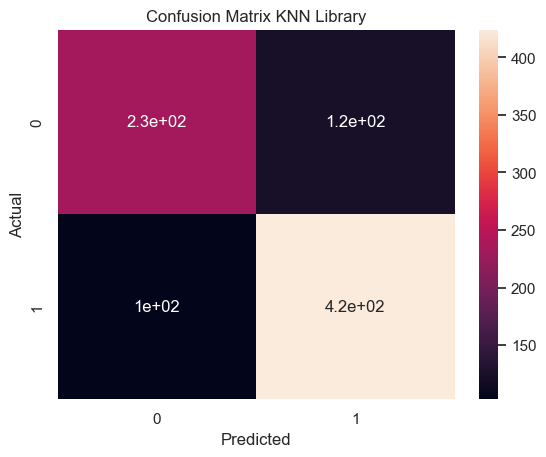

[[233 124]
 [103 424]]


In [11]:
################# KNN Library #################

if True:
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(train_df[important_attributes], train_df['diagnosed_diabetes'])
    # Make predictions
    predictions = knn.predict(test_df[important_attributes])
    # Calculate accuracy
    correct = sum(predictions == test_df['diagnosed_diabetes'])
    print(f"Accuracy for KNN: {correct/len(test_df)}")
    knn_accuracy = correct/len(test_df)
    # Plot confusion matrix
    cm = confusion_matrix(test_df['diagnosed_diabetes'], predictions)
    sns.heatmap(cm, annot=True)
    plt.title("Confusion Matrix KNN Library")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print(cm)


In [12]:
################# KNN Personal #################
if False:
    # This code has been disabled as it takes a lot of time to run
    # During testing, it was found to give the same results as the library implementation
    # It is left here for reference, but the library implementation is preferred due to its speed
    # Create KNN object
    knn = KNN(k=3)
    knn.store(train_df[important_attributes], train_df['diagnosed_diabetes'])
    # Make predictions
    predictions = knn.predict(test_df[important_attributes])
    # Calculate accuracy
    correct = sum(predictions == test_df['diagnosed_diabetes'])
    print(f"Accuracy: {correct/len(test_df)}")
    # Plot confusion matrix
    knn.plot_confusion_matrix(test_df[important_attributes], test_df['diagnosed_diabetes'])


Accuracy for Random Forest: 0.915158371040724


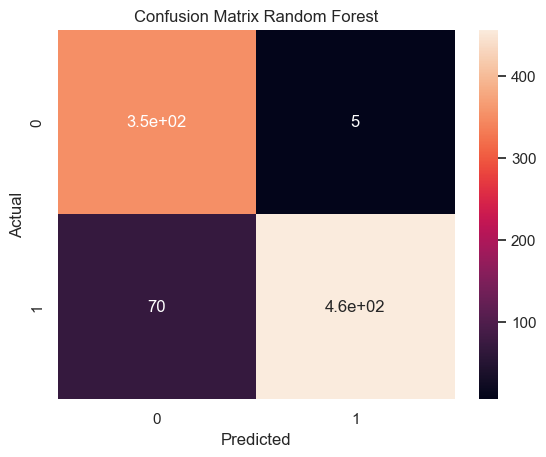

[[352   5]
 [ 70 457]]


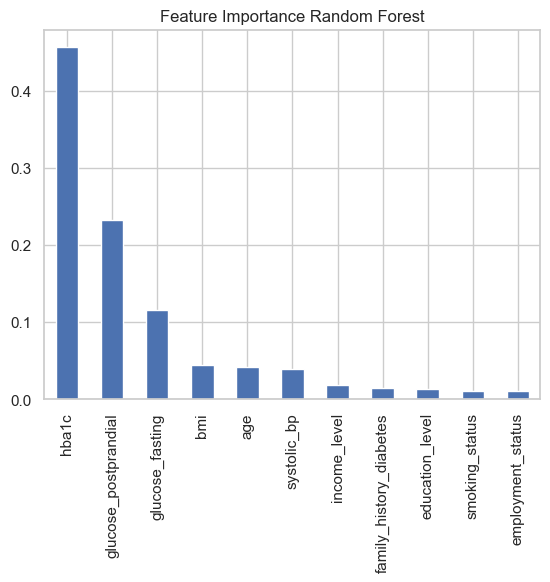

In [13]:
################# Random Forest #################
if True:
    random_forest = RandomForestClassifier(n_estimators=100)
    random_forest.fit(train_df[important_attributes], train_df['diagnosed_diabetes'])
    # Make predictions
    predictions = random_forest.predict(test_df[important_attributes])
    # Calculate accuracy
    correct = sum(predictions == test_df['diagnosed_diabetes'])
    print(f"Accuracy for Random Forest: {correct/len(test_df)}")
    random_forest_accuracy = correct/len(test_df)
    # Plot confusion matrix
    cm = confusion_matrix(test_df['diagnosed_diabetes'], predictions)
    sns.heatmap(cm, annot=True)
    plt.title("Confusion Matrix Random Forest")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print(cm)

    # Plot feature importance
    feature_importance = random_forest.feature_importances_
    feature_names = train_df[important_attributes].columns
    feature_importance = pd.Series(feature_importance, index=feature_names)
    feature_importance.sort_values(ascending=False, inplace=True)
    feature_importance.plot(kind='bar')
    plt.title("Feature Importance Random Forest")
    plt.show()
    # Shows a bar chart a bit different than the one from decision tree
    # Glucose postprandial has a higher importance but hba1c is still the most important


Accuracy for Gaussian NB: 0.8699095022624435


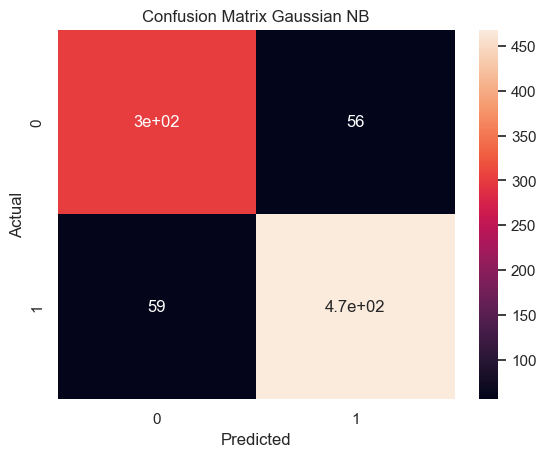

[[301  56]
 [ 59 468]]


In [14]:
################# Gaussian NB ######################

if True:
    gaussian_nb = GaussianNB()
    gaussian_nb.fit(train_df[important_attributes], train_df['diagnosed_diabetes'])
    # Make predictions
    predictions = gaussian_nb.predict(test_df[important_attributes])
    # Calculate accuracy
    correct = sum(predictions == test_df['diagnosed_diabetes'])
    print(f"Accuracy for Gaussian NB: {correct/len(test_df)}")
    gaussian_nb_accuracy = correct/len(test_df)
    # Plot confusion matrix
    cm = confusion_matrix(test_df['diagnosed_diabetes'], predictions)
    sns.heatmap(cm, annot=True)
    plt.title("Confusion Matrix Gaussian NB")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print(cm)


Accuracy for XG Boost: 0.9015837104072398


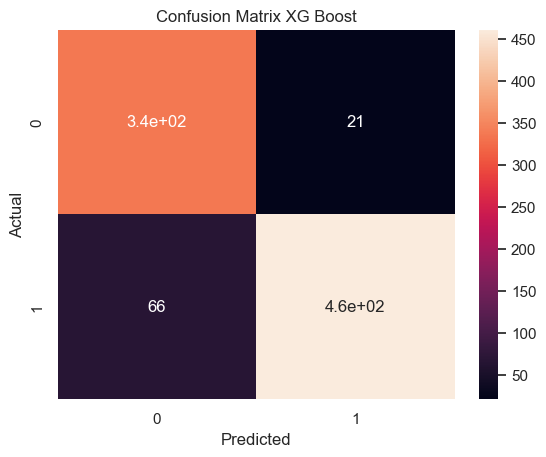

[[336  21]
 [ 66 461]]


In [15]:
###################### XG Boost ####################

if True:
    xgboost = XGBClassifier()
    xgboost.fit(train_df[important_attributes], train_df['diagnosed_diabetes'])
    # Make predictions
    predictions = xgboost.predict(test_df[important_attributes])
    # Calculate accuracy
    correct = sum(predictions == test_df['diagnosed_diabetes'])
    print(f"Accuracy for XG Boost: {correct/len(test_df)}")
    xgboost_accuracy = correct/len(test_df)
    # Plot confusion matrix
    cm = confusion_matrix(test_df['diagnosed_diabetes'], predictions)
    sns.heatmap(cm, annot=True)
    plt.title("Confusion Matrix XG Boost")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print(cm)


In [16]:
################# Model Comparison #################
print(f"Decision Tree Accuracy: {decision_tree_accuracy}")
print(f"KNN Accuracy: {knn_accuracy}")
print(f"Random Forest Accuracy: {random_forest_accuracy}")
print(f"Gaussian NB Accuracy: {gaussian_nb_accuracy}")
print(f"XG Boost Accuracy: {xgboost_accuracy}")
best_model = max(decision_tree_accuracy, knn_accuracy, random_forest_accuracy, gaussian_nb_accuracy)


if best_model == decision_tree_accuracy:
    best_model_name = "Decision Tree"
elif best_model == knn_accuracy:
    best_model_name = "KNN"
elif best_model == random_forest_accuracy:
    best_model_name = "Random Forest"
elif best_model == gaussian_nb_accuracy:
    best_model_name = "Gaussian NB"
elif best_model == xgboost_accuracy:
    best_model_name = "XG Boost"
print(f"\nBest Model: {best_model_name}")
print(f"{best_model_name} Accuracy: {best_model}")
with open("model_best.txt", "w") as f:
    f.write(best_model_name)


Decision Tree Accuracy: 0.8631221719457014
KNN Accuracy: 0.7432126696832579
Random Forest Accuracy: 0.915158371040724
Gaussian NB Accuracy: 0.8699095022624435
XG Boost Accuracy: 0.9015837104072398

Best Model: Random Forest
Random Forest Accuracy: 0.915158371040724
